In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/archive.zip .

In [ ]:
import zipfile
with zipfile.ZipFile("archive.zip", 'r') as zip_ref:
    zip_ref.extractall("archive")

In [ ]:
import os
print(os.listdir("archive"))

['test', 'train']


Step 1:Load the Dataset using PyTorch

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_dataset = datasets.ImageFolder(root='archive/train', transform=transform)
test_dataset = datasets.ImageFolder(root='archive/test', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
print("Class labels:", train_dataset.classes)

Class labels: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


Step 2: Visualize Some Training Images

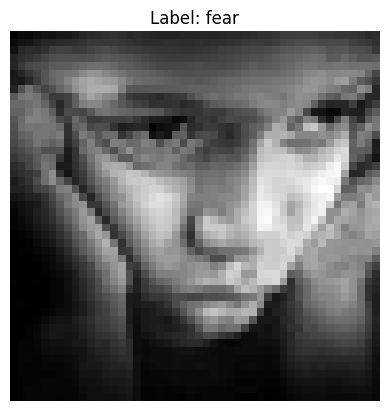

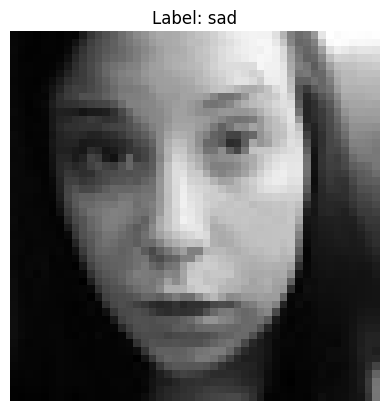

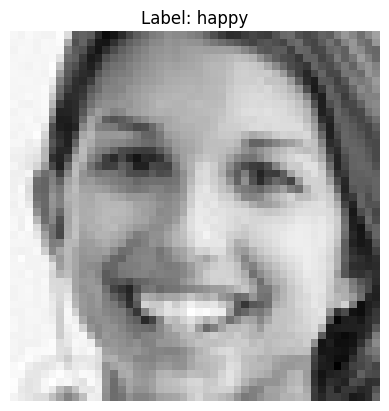

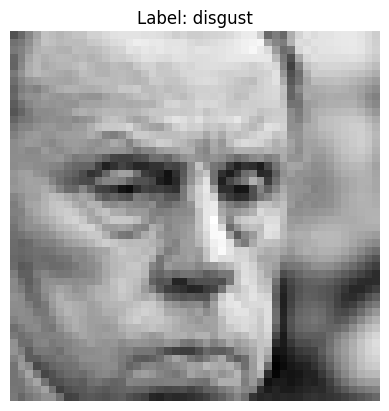

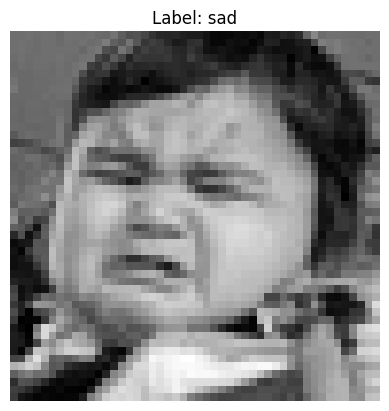

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
def imshow(img, label):
    img = img * 0.5 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.title("Label: " + label)
    plt.axis('off')
    plt.show()
dataiter = iter(train_loader)
images, labels = next(dataiter)
for i in range(5):
    imshow(images[i], train_dataset.classes[labels[i]])

 Step 3: Build the CNN Architecture

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
class EmotionCNN(nn.Module):
    def __init__(self):
        super(EmotionCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 6 * 6, 256)  # 6x6 from 48x48 after 3 pools
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 7)  # 7 output classes
    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 6 * 6)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

Step 4:Initialize the Model

In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model = EmotionCNN().to(device)

Using device: cuda


Step 5:Define Loss Function and Optimizer

In [ ]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Step 6: Training the CNN Model

In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

Epoch [1/10], Loss: 1.7364, Accuracy: 29.51%
Epoch [2/10], Loss: 1.5505, Accuracy: 37.57%
Epoch [3/10], Loss: 1.4681, Accuracy: 40.99%
Epoch [4/10], Loss: 1.4289, Accuracy: 43.35%
Epoch [5/10], Loss: 1.3923, Accuracy: 44.52%
Epoch [6/10], Loss: 1.3585, Accuracy: 46.22%
Epoch [7/10], Loss: 1.3218, Accuracy: 47.47%
Epoch [8/10], Loss: 1.3000, Accuracy: 48.17%
Epoch [9/10], Loss: 1.2636, Accuracy: 49.50%
Epoch [10/10], Loss: 1.2474, Accuracy: 49.98%


Step 7:Evaluate Model on Test Set

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)
target_names = train_dataset.classes
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=target_names))

Confusion Matrix:
 [[ 296    0   44   83   63  454   18]
 [  65    0    6    3    3   34    0]
 [ 130    0  182   66   76  479   91]
 [  35    0   32 1433  124  132   18]
 [  24    0   23   94  535  555    2]
 [ 109    0   46   81  191  814    6]
 [  15    0  163   71   14   73  495]]

Classification Report:
              precision    recall  f1-score   support

       angry       0.44      0.31      0.36       958
     disgust       0.00      0.00      0.00       111
        fear       0.37      0.18      0.24      1024
       happy       0.78      0.81      0.80      1774
     neutral       0.53      0.43      0.48      1233
         sad       0.32      0.65      0.43      1247
    surprise       0.79      0.60      0.68       831

    accuracy                           0.52      7178
   macro avg       0.46      0.43      0.43      7178
weighted avg       0.54      0.52      0.51      7178



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


###Summary:
**Dataset**: FER2013 (7 emotion classes)  
**Preprocessing**: Grayscale, resized to 48×48, normalized [-1, 1]  
**Model**: Custom CNN with Conv >> ReLU >> BatchNorm >> MaxPool layers  
**Training**: 10 epochs, Adam optimizer, CrossEntropyLoss  
**Accuracy**:
- Final training accuracy: **55.69%**
- Test accuracy: **52%**

**Best Performing Classes**: happy, surprise  
**Weak Class**: disgust (class imbalance)

**Evaluation**: Confusion matrix and classification report generated  
**Device Used**: GPU (CUDA)


